<a href="https://colab.research.google.com/github/Mahsa-Goudarzi/industrial-automation/blob/main/linear-programming-project/Industrial_Automation_MILP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MILP solver

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 24.1 MB/s eta 0:00:00


In [ ]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary, LpContinuous, value
import time

# Define constants
jobs = ['J1', 'J2', 'J3', 'J4', 'J5']
machines = ['M1', 'M2', 'M3', 'M4', 'M5']
operations = [1, 2, 3]
machine_ids = {m: i for i, m in enumerate(machines)}
M = 1000  # Big-M constant

# Processing and transfer times
proc_times = {
    'J1': [10, 11, 9, 12, 8],
    'J2': [11, 9, 10, 11, 9],
    'J3': [12, 13, 11, 10, 11],
    'J4': [9, 10, 12, 11, 10],
    'J5': [10, 11, 8, 9, 7],
}
transfer_times = [
    [0, 1, 2, 3, 2],
    [1, 0, 2, 2, 2],
    [2, 2, 0, 2, 1],
    [3, 2, 2, 0, 1],
    [2, 2, 1, 1, 0],
]

# Create problem
prob = LpProblem("Electronics_Assembly_Scheduling", LpMinimize)

# Decision variables
x = {(j, o, m): LpVariable(f"x_{j}_{o}_{m}", cat=LpBinary)
     for j in jobs for o in operations for m in machines}
s = {(j, o): LpVariable(f"s_{j}_{o}", lowBound=0, cat=LpContinuous)
     for j in jobs for o in operations}
C_max = LpVariable("C_max", lowBound=0, cat=LpContinuous)

# Objective: minimize makespan
prob += C_max

# Constraint 1: Each operation assigned to one machine
for j in jobs:
    for o in operations:
        prob += lpSum(x[j, o, m] for m in machines) == 1

# Constraint 2: J5 must use M1 and M2 at least once, at most twice
prob += lpSum(x['J5', o, 'M1'] for o in operations) >= 1
prob += lpSum(x['J5', o, 'M1'] for o in operations) <= 2
prob += lpSum(x['J5', o, 'M2'] for o in operations) >= 1
prob += lpSum(x['J5', o, 'M2'] for o in operations) <= 2

# Constraint 3: Operation sequencing + transfer times (Big-M)
for j in jobs:
    for o in [1, 2]:
        for m1 in machines:
            for m2 in machines:
                m1_id = machine_ids[m1]
                m2_id = machine_ids[m2]
                proc = proc_times[j][m1_id]
                trans = transfer_times[m1_id][m2_id]
                prob += s[j, o + 1] >= s[j, o] + proc + trans - M * (2 - x[j, o, m1] - x[j, o + 1, m2])

# Constraint 5: Makespan >= end of last operation
for j in jobs:
    for m in machines:
        m_id = machine_ids[m]
        prob += C_max >= s[j, 3] + proc_times[j][m_id] * x[j, 3, m]

# Constraint 4: No overlap on the same machine for different jobs
y = {}
for m in machines:
    for j1 in jobs:
        for j2 in jobs:
            if j1 >= j2:
                continue
            for o1 in operations:
                for o2 in operations:
                    y[(j1, j2, o1, o2, m)] = LpVariable(f"y_{j1}_{j2}_{o1}_{o2}_{m}", cat=LpBinary)
                    m_id = machine_ids[m]
                    p1 = proc_times[j1][m_id]
                    p2 = proc_times[j2][m_id]
                    # Disjunctive no-overlap constraint (Big-M)
                    prob += s[j1, o1] + p1 <= s[j2, o2] + M * (1 - y[(j1, j2, o1, o2, m)]) + M * (2 - x[j1, o1, m] - x[j2, o2, m])
                    prob += s[j2, o2] + p2 <= s[j1, o1] + M * y[(j1, j2, o1, o2, m)] + M * (2 - x[j1, o1, m] - x[j2, o2, m])


# Solve the problem
start_time = time.time()
prob.solve()
end_time = time.time()

# Output schedule and makespan
print("✅ Optimal Schedule Found")
print("📦 Makespan:", value(C_max))
print("\n📋 Detailed Schedule (Sorted by Start Time):")
schedule = []
for j in jobs:
    for o in operations:
        for m in machines:
            if x[j, o, m].varValue == 1:
                schedule.append((value(s[j, o]), j, o, m))
for entry in sorted(schedule):
    print(f" - Start: {entry[0]:.1f} min | Job: {entry[1]}, Operation {entry[2]}, Machine: {entry[3]}")

print(f"\nComputation Time: {end_time - start_time:.3f} seconds")

✅ Optimal Schedule Found
📦 Makespan: 31.0

📋 Detailed Schedule (Sorted by Start Time):
 - Start: 0.0 min | Job: J1, Operation 1, Machine: M3
 - Start: 0.0 min | Job: J2, Operation 1, Machine: M1
 - Start: 0.0 min | Job: J3, Operation 1, Machine: M4
 - Start: 0.0 min | Job: J4, Operation 1, Machine: M5
 - Start: 0.0 min | Job: J5, Operation 1, Machine: M2
 - Start: 9.0 min | Job: J1, Operation 2, Machine: M3
 - Start: 10.0 min | Job: J3, Operation 2, Machine: M4
 - Start: 10.0 min | Job: J4, Operation 2, Machine: M5
 - Start: 12.0 min | Job: J5, Operation 2, Machine: M1
 - Start: 13.0 min | Job: J2, Operation 2, Machine: M2
 - Start: 21.0 min | Job: J3, Operation 3, Machine: M4
 - Start: 22.0 min | Job: J1, Operation 3, Machine: M3
 - Start: 22.0 min | Job: J2, Operation 3, Machine: M2
 - Start: 22.0 min | Job: J4, Operation 3, Machine: M1
 - Start: 24.0 min | Job: J5, Operation 3, Machine: M5

Computation Time: 90.075 seconds


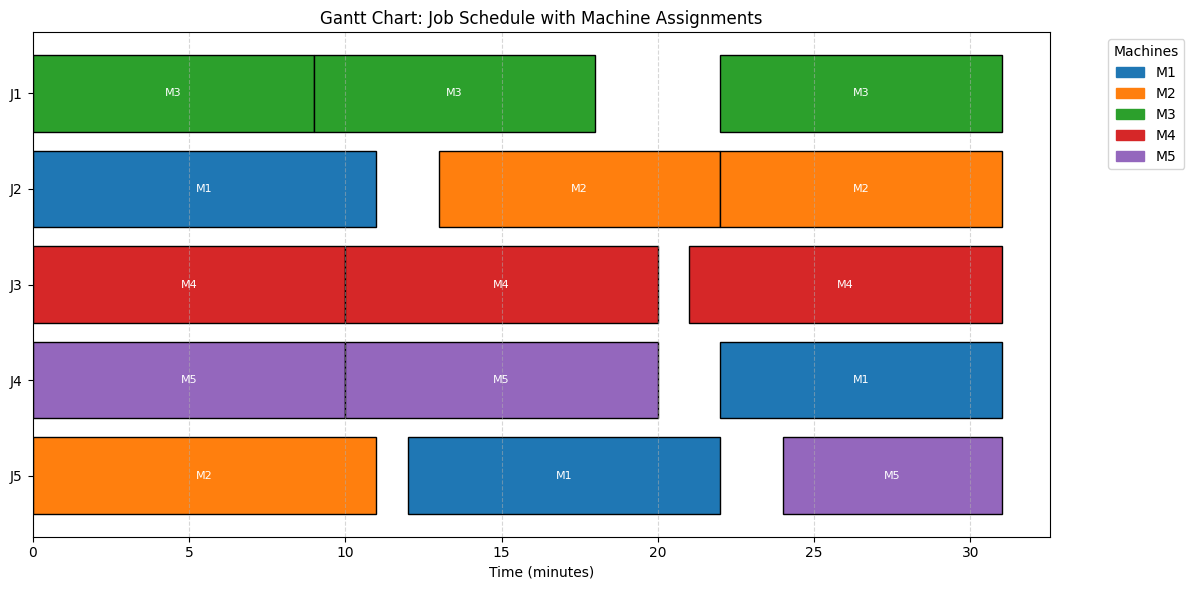

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Color map for machines
color_map = {
    'M1': 'tab:blue',
    'M2': 'tab:orange',
    'M3': 'tab:green',
    'M4': 'tab:red',
    'M5': 'tab:purple',
}

# Prepare Gantt chart data
gantt_data = []
for start, j, o, m  in schedule:
    machine_id = machine_ids[m]
    duration = proc_times[j][machine_id]
    gantt_data.append((j, o, m, start, duration))

# Sort for plotting
gantt_data.sort(key=lambda x: x[3])
y_pos = {j: i for i, j in enumerate(reversed(jobs))}

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
for j, o, m, start, duration in gantt_data:
    ax.barh(y_pos[j], duration, left=start, color=color_map[m], edgecolor='black')
    ax.text(start + duration / 2, y_pos[j], f"{m}", va='center', ha='center', color='white', fontsize=8)

# Axis and labels
ax.set_yticks(list(y_pos.values()))
ax.set_yticklabels(list(y_pos.keys()))
ax.set_xlabel("Time (minutes)")
ax.set_title("Gantt Chart: Job Schedule with Machine Assignments")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# Legend
handles = [mpatches.Patch(color=color, label=m) for m, color in color_map.items()]
ax.legend(handles=handles, title="Machines", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#Greedy method

In [ ]:
# Define constants
jobs = ['J1', 'J2', 'J3', 'J4', 'J5']
machines = ['M1', 'M2', 'M3', 'M4', 'M5']
operations = [1, 2, 3]
machine_ids = {m: i for i, m in enumerate(machines)}
M = 1000  # Big-M constant

# Processing and transfer times
proc_times = {
    'J1': [10, 11, 9, 12, 8],
    'J2': [11, 9, 10, 11, 9],
    'J3': [12, 13, 11, 10, 11],
    'J4': [9, 10, 12, 11, 10],
    'J5': [10, 11, 8, 9, 7],
}
transfer_times = [
    [0, 1, 2, 3, 2],
    [1, 0, 2, 2, 2],
    [2, 2, 0, 2, 1],
    [3, 2, 2, 0, 1],
    [2, 2, 1, 1, 0],
]

# Identify machine availability
machine_available = {m: 0 for m in machines}
schedule = []

# Helper function, find the best possible machine
def find_best_machine(job, prev_machine, prev_end):
    best_m = None
    best_end = float('inf')
    for m in machines:
        m_id = machine_ids[m]
        proc = proc_times[job][m_id]
        avail = machine_available[m]
        trans = transfer_times[machine_ids[prev_machine]][m_id] if prev_machine else 0
        start = max(avail, prev_end + trans)
        end = start + proc
        if end < best_end:
            best_end = end
            best_m = m
    return best_m

start_time = time.time()

# Schedule jobs
for j in jobs:
    used = []
    prev_machine = None
    prev_end = 0

    if j == 'J5':
        # Establish op 1 on M1
        m1 = 'M1'
        m1_id = machine_ids[m1]
        trans1 = transfer_times[machine_ids[prev_machine]][m1_id] if prev_machine else 0
        start1 = max(machine_available[m1], prev_end + trans1)
        dur1 = proc_times[j][m1_id]
        end1 = start1 + dur1
        schedule.append((start1, j, 1, m1))
        machine_available[m1] = end1
        prev_machine = m1
        prev_end = end1
        used.append(m1)

        # Establish op 2 on M2
        m2 = 'M2'
        m2_id = machine_ids[m2]
        trans2 = transfer_times[m1_id][m2_id]
        start2 = max(machine_available[m2], prev_end + trans2)
        dur2 = proc_times[j][m2_id]
        end2 = start2 + dur2
        schedule.append((start2, j, 2, m2))
        machine_available[m2] = end2
        prev_machine = m2
        prev_end = end2
        used.append(m2)

        # Op 3: best remaining machine
        m3 = find_best_machine(j, prev_machine, prev_end)
        m3_id = machine_ids[m3]
        trans3 = transfer_times[machine_ids[prev_machine]][m3_id]
        start3 = max(machine_available[m3], prev_end + trans3)
        dur3 = proc_times[j][m3_id]
        end3 = start3 + dur3
        schedule.append((start3, j, 3, m3))
        machine_available[m3] = end3

    else:
        for o in [1, 2, 3]:
            m = find_best_machine(j, prev_machine, prev_end)
            m_id = machine_ids[m]
            trans = transfer_times[machine_ids[prev_machine]][m_id] if prev_machine else 0
            start = max(machine_available[m], prev_end + trans)
            dur = proc_times[j][m_id]
            end = start + dur
            schedule.append((start, j, o, m))
            machine_available[m] = end
            prev_machine = m
            prev_end = end
            used.append(m)

end_time = time.time()

# Sort and print schedule
schedule.sort()
print("Greedy Schedule with Transfer Times:")
for t, j, o, m in schedule:
    print(f" - Start: {t:.1f} min | Job: {j}, Operation {o}, Machine: {m}")

makespan = max(machine_available.values())
print(f"\nEstimated Makespan: {makespan:.1f} min")

print(f"\nComputation Time: {end_time - start_time:.3f} seconds")


Greedy Schedule with Transfer Times:
 - Start: 0.0 min | Job: J1, Operation 1, Machine: M5
 - Start: 0.0 min | Job: J2, Operation 1, Machine: M2
 - Start: 0.0 min | Job: J3, Operation 1, Machine: M4
 - Start: 0.0 min | Job: J4, Operation 1, Machine: M1
 - Start: 8.0 min | Job: J1, Operation 2, Machine: M5
 - Start: 9.0 min | Job: J2, Operation 2, Machine: M2
 - Start: 9.0 min | Job: J4, Operation 2, Machine: M1
 - Start: 10.0 min | Job: J3, Operation 2, Machine: M4
 - Start: 16.0 min | Job: J1, Operation 3, Machine: M5
 - Start: 18.0 min | Job: J2, Operation 3, Machine: M2
 - Start: 18.0 min | Job: J4, Operation 3, Machine: M1
 - Start: 20.0 min | Job: J3, Operation 3, Machine: M4
 - Start: 27.0 min | Job: J5, Operation 1, Machine: M1
 - Start: 38.0 min | Job: J5, Operation 2, Machine: M2
 - Start: 51.0 min | Job: J5, Operation 3, Machine: M5

Estimated Makespan: 58.0 min

Computation Time: 0.001 seconds


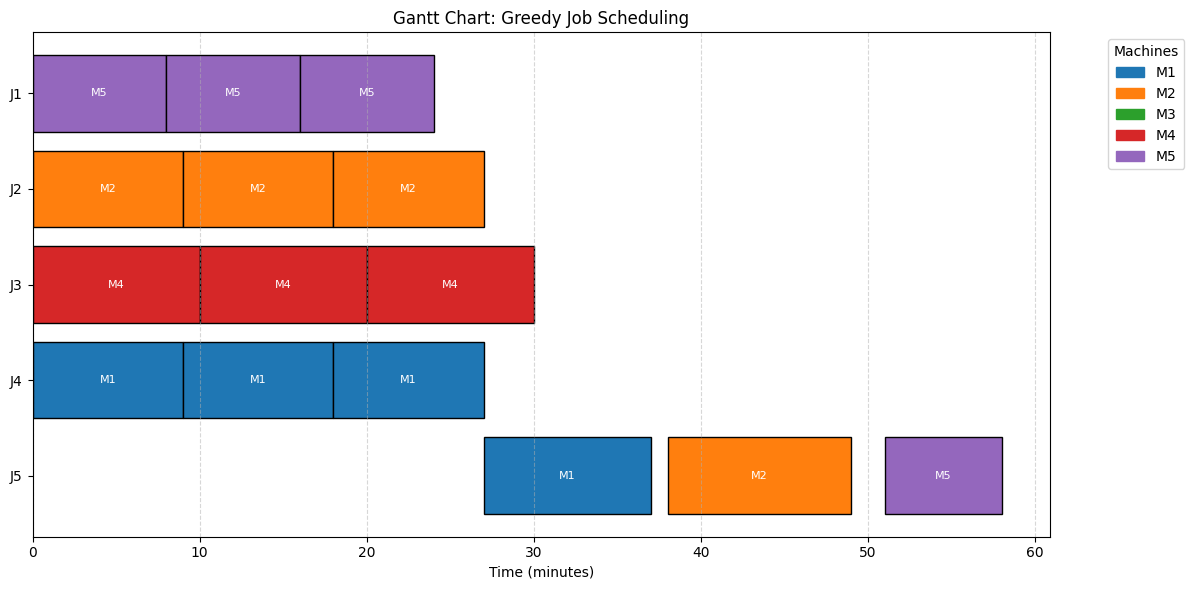

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

color_map = {
    'M1': 'tab:blue',
    'M2': 'tab:orange',
    'M3': 'tab:green',
    'M4': 'tab:red',
    'M5': 'tab:purple',
}

gantt_data = []
for start, j, o, m in schedule:
    machine_id = machine_ids[m]
    duration = proc_times[j][machine_id]
    gantt_data.append((j, o, m, start, duration))

gantt_data.sort(key=lambda x: x[3])
y_pos = {j: i for i, j in enumerate(reversed(jobs))}

fig, ax = plt.subplots(figsize=(12, 6))
for j, o, m, start, duration in gantt_data:
    ax.barh(y_pos[j], duration, left=start, color=color_map[m], edgecolor='black')
    ax.text(start + duration / 2, y_pos[j], f"{m}", va='center', ha='center', color='white', fontsize=8)

ax.set_yticks(list(y_pos.values()))
ax.set_yticklabels(list(y_pos.keys()))
ax.set_xlabel("Time (minutes)")
ax.set_title("Gantt Chart: Greedy Job Scheduling")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

handles = [mpatches.Patch(color=color, label=m) for m, color in color_map.items()]
ax.legend(handles=handles, title="Machines", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
